# Clustering

## Something small that works

In [1]:
import os

from skimage import io, transform
from sklearn.feature_extraction.image import extract_patches_2d

dataDir = 'images/archive/bloodcells_dataset'

patchSize = (2, 2)
targetSize = (100, 100)

# Listen zum Speichern aller Patches und zugehöriger Labels
allPatches = []
imgPatches = []

for label, subDir in enumerate(os.listdir(dataDir)):
    subDirPath = os.path.join(dataDir, subDir)
    
    for imgFileName in os.listdir(subDirPath):
        imgPath = os.path.join(subDirPath, imgFileName)
        # Lade das Bild
        img = io.imread(imgPath)
        # Skaliere das Bild auf 100x100
        img = transform.resize(img, targetSize)
        # Extrahiere Patches aus dem skalierten Bild
        imgPatches = extract_patches_2d(img, patchSize, max_patches=50, random_state=0)
        
def convert_patches(patches):
    # In 2D-Array konvertieren
    patches = patches.reshape(-1, patches.shape[1] * patches.shape[2])
    
    return patches

allPatches = convert_patches(imgPatches)


In [2]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Erstelle das Modell
model = AgglomerativeClustering(n_clusters=8)

# Trainiere das Modell
model.fit(allPatches)

# Hole die Cluster-Labels ab
labels = model.labels_

# Berechne den Silhouette-Score
silhouette_score = silhouette_score(allPatches, labels)

# Drucke den Silhouette-Score aus
print(f"Silhouette-Score: {silhouette_score:.2f}")

Silhouette-Score: 0.68


In [22]:
from sklearn.metrics import pairwise_distances

# Definiere die Variable train_patches
train_patches = allPatches[:int(0.75 * len(allPatches))]

# Initialisiere das Array, um die Silhouette-Scores zu speichern
silhouette_scores = []

for n_clusters in range(2, 11):

    # Erstelle ein Modell mit der angegebenen Anzahl der Cluster
    model = AgglomerativeClustering(n_clusters=n_clusters)

    # Trainiere das Modell
    model.fit(train_patches)

    # Berechne die Distanzen zwischen allen Datenpunkten
    distances = pairwise_distances(train_patches)

    # Berechne den Silhouette-Score für die Datenpunkte in train_patches
    silhouette_scores.append(silhouette_score(distances, model.labels_))

# Drucke die Silhouette-Scores aus
for silhouette_score in silhouette_scores:
    print(f"Silhouette-Score für {n_clusters} Cluster: {silhouette_score:.2f}")


TypeError: 'numpy.float64' object is not callable

## Testing ground   

In [1]:
# Bilder einlesen und Informationen speichern

import os
from skimage import io, transform

dataDir = 'images/archive/bloodcells_dataset'

filepaths = []
labels = []
images = []

# Gehe durch die Unterordner im dataDir
for subdir in os.listdir(dataDir):
    subdir_path = os.path.join(dataDir, subdir)
    # Gehe durch die Dateien im Unterordner
    for filename in os.listdir(subdir_path):
        filepath = os.path.join(subdir_path, filename)
        # File info and label
        filepaths.append(filepath)
        labels.append(subdir)
        # Lade das Bild
        img = io.imread(filepath)
        images.append(img)

In [2]:
# Dataframe für organisation und konvertierung

import pandas as pd

df_cells = df = pd.DataFrame({'filepaths': filepaths, 'labels': labels, 'images': images})

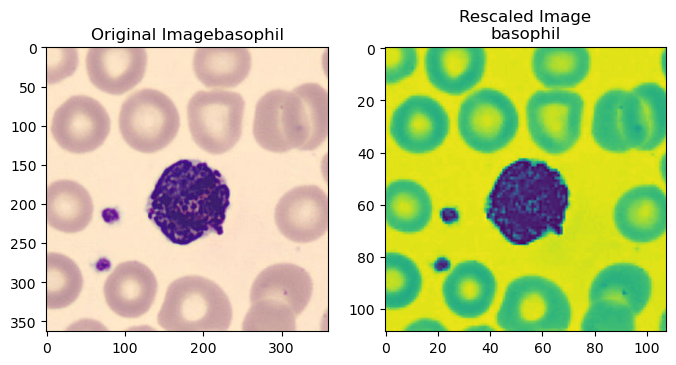

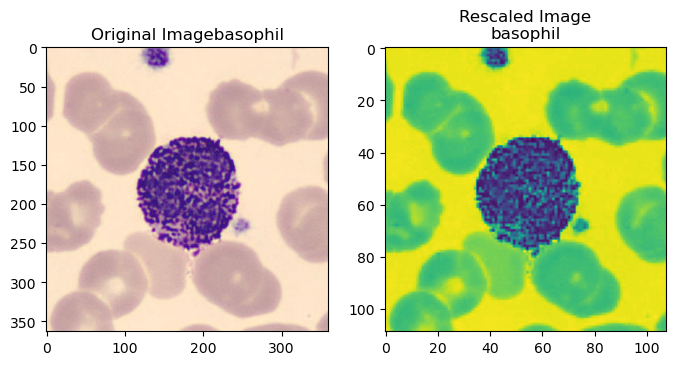

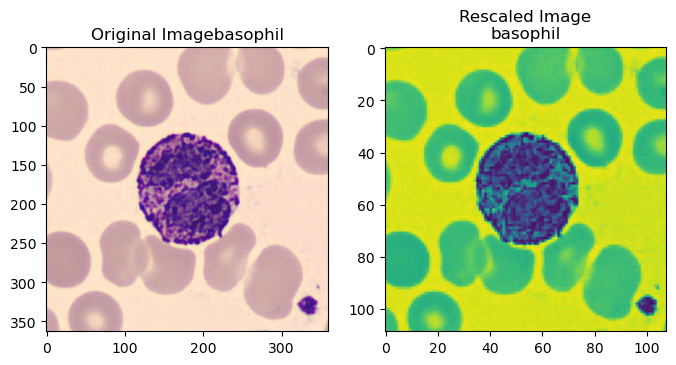

In [3]:
# Extract features or perform other image processing tasks
# For example, you can use scikit-image's transform module to resize the images
rescaled_images = [transform.rescale(img, 0.3, mode="reflect", anti_aliasing=False) for img in images]
df['scaled_images_30'] = rescaled_images
    
# Perform additional processing or analysis as needed
# For example, you might want to display the original and rescaled images
import matplotlib.pyplot as plt

# Display original and rescaled images side by side for the first few images
num_images_to_display = 3
for i in range(num_images_to_display):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])
    plt.title('Original Image\n' + labels[i])
    
    plt.subplot(1, 2, 2)
    plt.imshow(rescaled_images[i])
    plt.title('Rescaled Image\n' + labels[i])
    
    plt.show()

In [ ]:
import multiprocessing
from functools import partial
from skimage import feature, color
import numpy as np

# Feature extraction functions
def extract_hog_features(img):
    return feature.hog(color.rgb2gray(img))

def extract_color_histogram(img):
    flattened_img = img.flatten()
    hist, _ = np.histogram(flattened_img, bins=256, range=(0, 256))
    return hist

def extract_gray_histogram(img):
    flattened_img = img.flatten()
    hist, _ = np.histogram(flattened_img, bins=256, range=(0, 256))
    return hist  # Corrected the return variable to 'hist'

# Function to extract features from a single image
def extract_features(img):
    # Extract HOG features
    hog_feat = extract_hog_features(img)
    # Extract color histogram features
    color_hist = extract_color_histogram(img)
    # Convert the image to grayscale and extract grayscale features
    gray_img = color.rgb2gray(img)
    gray_hist = extract_gray_histogram(gray_img)
    return hog_feat, color_hist, gray_hist

def driver_func():
    # Create a Pool of worker processes
    with multiprocessing.Pool(6) as pool:
        # Map the images to worker processes to extract features in parallel
        results = [pool.apply_async(extract_features, image) for image in images]

        # Collect the results
        extracted_hog_features = []
        extracted_color_histograms = []
        extracted_gray_histograms = []
        
        for result in results:
            hog_feat, color_hist, gray_hist = result.get()
            extracted_hog_features.append(hog_feat)
            extracted_color_histograms.append(color_hist)
            extracted_gray_histograms.append(gray_hist)

    # Now, you have the extracted features in separate lists
    return extracted_hog_features, extracted_color_histograms, extracted_gray_histograms  

hog_features, color_histograms, gray_histograms = driver_func()

In [ ]:
# Combine the features for feature agglomeration
features_for_agglomeration = np.vstack(df['hog_features'])

# Perform Feature Agglomeration
from sklearn.cluster import FeatureAgglomeration

n_clusters = 50  # Adjust as needed
feature_agglomeration = FeatureAgglomeration(n_clusters=n_clusters)
X_reduced = feature_agglomeration.fit_transform(features_for_agglomeration)

# Display the reduced feature matrix
print(X_reduced.shape)

In [18]:
import numpy as np

X = np.reshape(images, len(images), -1)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17092,) + inhomogeneous part.

In [ ]:
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering

connectivity = grid_to_graph(*rescaled_cells_list.shape)

n_clusters = 8  # Anzahl der Blutzellentypen
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward", connectivity=connectivity)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_cells_list.shape)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(rescaled_cells_list, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(
        label == l,
        colors=[plt.cm.nipy_spectral(l / float(n_clusters))],
    )
plt.axis("off")
plt.show()